<a href="https://colab.research.google.com/github/Ashutosh-Tiwari-23/Machine-Learning-Projects/blob/main/Dog_Breed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dog Breed Prediction


  In this project, we will see how to use Keras and tensorflow to build, train, and test a Convolutional Neural Network capable of identifying the breed of a dog in a supplied image. This is a supervised learning problem, specifically for a multiclass classification problem.

In [1]:
# to connect google colab with kaggle, download the kaggle.json file from kaggle and upload it here
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashutosh2811","key":"bc538af3ee354cd10124657bb3e3644f"}'}

In [2]:
# install the kaggle API client
!pip install -q kaggle

In [3]:
# The Kaggle API client expects this file to be in ~/. kaggle, so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

These step were to setup the kaggle api

In [4]:
# Creating a new working directory to store the data , and make this as working directory
!mkdir dog_dataset
%cd dog_dataset

/content/dog_dataset


In [5]:
# Next step : to search the Kaggle for the required data set in order to store the datas
!kaggle datasets list -s dogbreedidfromcomp

ref                                title                    size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------  ----------------------  -----  -------------------  -------------  ---------  ---------------  
catherinehorng/dogbreedidfromcomp  dog-breed-id-from-comp  691MB  2020-06-26 03:09:05           6357          8  0.1764706        


The above step is to search the Kaggle for the required dataset using search option(-s) with title 'dogbreedidfromcomp'. We can also use different search options like searching competitions, notebooks, kernels, datasets, etc.

In [6]:
# we will download this data from kaggle dataset
# Downloading dataset and coming out of directory
!kaggle datasets download catherinehorng/dogbreedidfromcomp
%cd ..

Dataset URL: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp
License(s): unknown
 99% 682M/691M [00:05<00:00, 107MB/s]
100% 691M/691M [00:05<00:00, 121MB/s]
/content


In [7]:
# Un zip the downloaded data, remove the unusable files
!unzip dog_dataset/dogbreedidfromcomp.zip -d dog_dataset
!rm dog_dataset/dogbreedidfromcomp.zip
!rm dog_dataset/sample_submission.csv

Streaming output truncated to the last 5000 lines.
  inflating: dog_dataset/train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: dog_dataset/train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: dog_dataset/train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: dog_dataset/train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: dog_dataset/train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: dog_dataset/train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: dog_dataset/train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: dog_dataset/train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: dog_dataset/train/83fad0718581a696132c96c166472627.jpg  
  inflating: dog_dataset/train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: dog_dataset/train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: dog_dataset/train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: dog_dataset/train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: dog_dataset/train/840db91b

In [8]:
# the data is prepared, let's start building the model
# important librabry imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam

In [9]:
# Next step : loading the labels data into the dataframe and view it
# read the labels.csv file and check the shape and records
labels_all = pd.read_csv('dog_dataset/labels.csv')
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Loading the labels data into dataframe and viewing it. Analysed that labels contains 10222 rows and 2 columns

In [10]:
# Visualize the number of each breeds
breeds_all = labels_all['breed']
breed_counts = breeds_all.value_counts()
breed_counts.head()


breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
Name: count, dtype: int64

Here we are finding out the count per class i.e. the total data in each class using value_counts() function

In [11]:
# Selecting first 3 breeds ( limitation due to computation power)
CLASS_NAMES = ['scottish_deerhound', 'maltese_dog', 'bernese_mountain_dog']
labels = labels_all[labels_all['breed'].isin(CLASS_NAMES)]
labels = labels.reset_index()
labels.head()

,index,id,breed
0,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
1,12,00693b8bc2470375cc744a6391d397ec,maltese_dog
2,79,01e787576c003930f96c966f9c3e1d44,scottish_deerhound
3,90,022b34fd8734b39995a9f38a4f3e7b6b,maltese_dog
4,118,02d54f0dfb40038765e838459ae8c956,bernese_mountain_dog


As we are working with the classification dataset first we need to one hot encode the target value i.e. the classes. After that we will read images and convert them into numpy array and finally normalize the array

In [12]:
# creating the numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# reading and converting image into numpy array and normalize the data set

for i in tqdm(range(len(labels))):
    img = image.load_img('dog_dataset/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)
    x = np.expand_dims(img.copy(), axis=0)
    X_data[i] = x / 255.

# Printing train image and one hot encode shape and size
print('Train Images shape: ',X_data.shape, 'size : {:,}'.format(X_data.size))
print('One hot encoded output shape:',Y_data.shape, 'size : {:,}'.format(Y_data.size))

100%|██████████| 357/357 [00:00<00:00, 514.37it/s]

Train Images shape:  (357, 224, 224, 3) size : 53,738,496
One hot encoded output shape: (357, 3) size : 1,071


In [13]:
# Building the model
model = Sequential()  # considering the sequential model

# Conv2d, maxpool2d flatten are the layers for this model. Playing with the hyperparameters
# 1st layer = conv2d layer
model.add(Conv2D(filters = 64, kernel_size = (5, 5), activation='relu', input_shape = (224,224,3)))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))
# MaxPool layer finds out the most prominant features in the 2x2 matrix

model.add(Conv2D(filters = 16, kernel_size = (7, 7), activation='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters = 8, kernel_size = (5, 5), activation='relu', kernel_regularizer = 'l2'))
model.add(MaxPool2D(pool_size=(2,2)))

# After setting up the layers, we will flatten the data as we need to apply the dense layer

model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_regularizer = 'l2'))
model.add(Dense(64, activation='relu', kernel_regularizer = 'l2'))
model.add(Dense(len(CLASS_NAMES), activation='softmax'))

# softmax gives the probability of classes. So in a multiclass classification problem we generally
# takes softmax as the activation function.

# Compiling the model
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 108, 108, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 16)        25104     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 16)        0

So the above step was to create the network architecture for the model. Different types of layers according to their features namely Conv_2d (used to convolutional kernel that is convolved with the input layer to produce the output sensor) , max_pooling2d (it is a down sampling technique which takes out maximum value over the window defined by pool size), flatten( it flattens the input and creates the 1D output), Dense (Dense layer produce the output as  the dot product of the input and the kernel).

In [14]:
# Splitting the data into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

In [20]:
# Taining the model / fit our model

epochs = 200
batch_size = 128

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, validation_data = (X_val, Y_val))

Epoch 1/200
2/2 [==============================] - 6s 3s/step - loss: 2.7302 - accuracy: 0.9531 - val_loss: 3.3987 - val_accuracy: 0.7385
Epoch 2/200
2/2 [==============================] - 5s 3s/step - loss: 2.7109 - accuracy: 0.9453 - val_loss: 3.4781 - val_accuracy: 0.6769
Epoch 3/200
2/2 [==============================] - 5s 3s/step - loss: 2.7171 - accuracy: 0.9414 - val_loss: 3.4114 - val_accuracy: 0.7385
Epoch 4/200
2/2 [==============================] - 5s 3s/step - loss: 2.7067 - accuracy: 0.9570 - val_loss: 3.3824 - val_accuracy: 0.6462
Epoch 5/200
2/2 [==============================] - 5s 3s/step - loss: 2.6844 - accuracy: 0.9766 - val_loss: 3.3751 - val_accuracy: 0.6923
Epoch 6/200
2/2 [==============================] - 5s 3s/step - loss: 2.6647 - accuracy: 0.9609 - val_loss: 3.3776 - val_accuracy: 0.6923
Epoch 7/200
2/2 [==============================] - 5s 3s/step - loss: 2.6729 - accuracy: 0.9609 - val_loss: 3.3768 - val_accuracy: 0.6769
Epoch 8/200
2/2 [=================

training the model on 100 epochs and batch size of 128, can try using more number of epochs to increase the accuracy. During each epochs we can see how the model is performing by viewing the training and validation accuracy

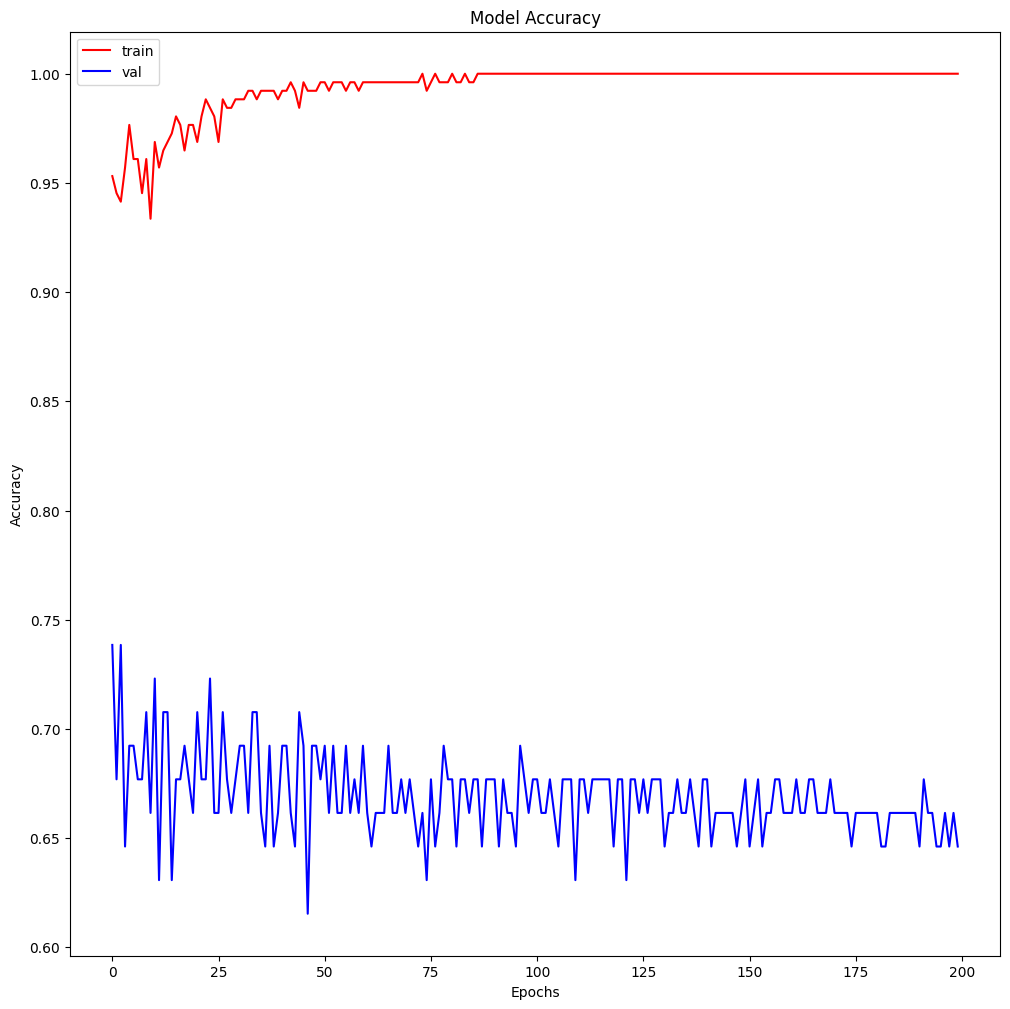

In [21]:
# Plot the training history

plt.figure(figsize=(12, 12))
plt.plot(history.history['accuracy'], color ='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])
plt.show()

In [22]:
# predicting activity by the model
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

2/2 [==============================] - 0s 29ms/step - loss: 3.2127 - accuracy: 0.6944
Accuracy over the test set: 
  69.44 %


On changing the mnodel's hypermeters / hyperparameter tuning , we can achieve better accuracy

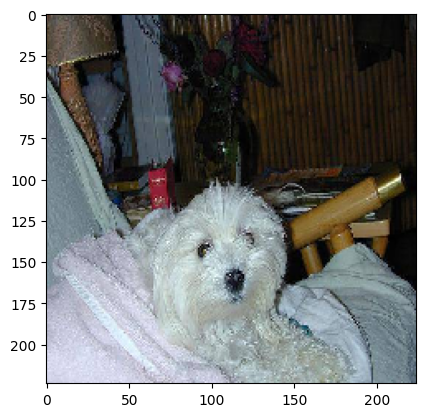

Originally :  maltese_dog
Predicted :  scottish_deerhound


In [23]:
# Plot the image to compare
plt.imshow(X_test[1, :, :, :])
plt.show()

# Finding the max value from prediction list and compareing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

In [25]:
# saving the model
model.save('dog_breed_classification_model.h5') # h5 is the format for saving the model

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
